# Titanic - Machine Learning from Disaster

## The Challenge
The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

### Loading necessary Modules

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import re
import math

pd.set_option('display.max_columns', 500)
plt.rcParams['figure.facecolor'] = 'w'

In [2]:
train_set = ('./train.csv')
test_set = ('./test.csv')
gender_submission = ('./gender_submission.csv')
glob.glob('./*')

['.\\gender_submission.csv',
 '.\\notebook.ipynb',
 '.\\test.csv',
 '.\\train.csv']

In [3]:
train = pd.read_csv(train_set)
test = pd.read_csv(test_set)
gender = pd.read_csv(gender_submission)

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
gender.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


### Exploratory Data Analysis

Definitions for the data used can be found here:
https://www.kaggle.com/competitions/titanic/data?select=train.csv

Credits to **Ken Jee**, Reference Source:
https://www.kaggle.com/code/kenjee/titanic-project-example/notebook

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
train.isna().sum().sort_values(ascending = False)

Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

In [9]:
train.loc[train['Age'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S


In [10]:
# train.dropna(subset = 'Embarked', inplace = True)
# train.isna().sum()

In [11]:
train.loc[train['Cabin'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
884,885,0,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,S
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [12]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


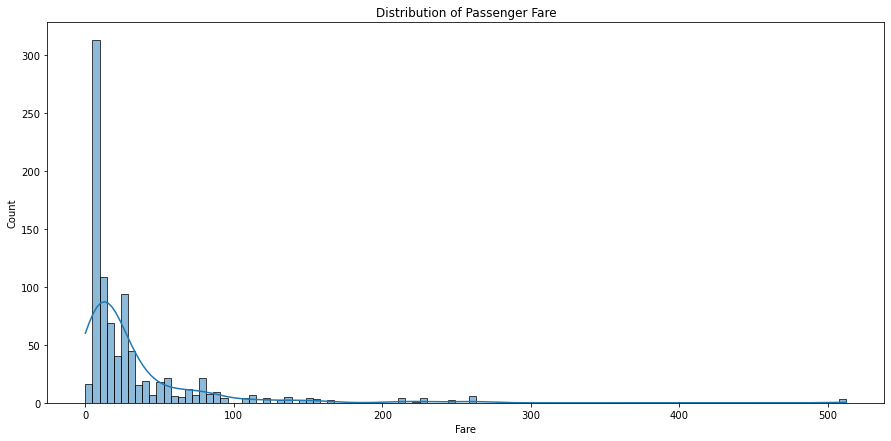

In [13]:
fig,ax = plt.subplots(figsize = (15,7))
sns.histplot(x = 'Fare', data = train, kde = True)
plt.title('Distribution of Passenger Fare')
plt.show()

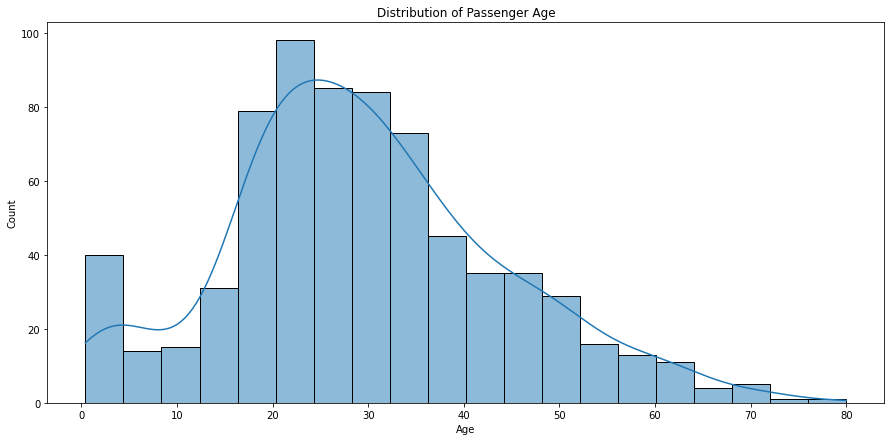

In [14]:
fig,ax = plt.subplots(figsize = (15,7))
sns.histplot(x = 'Age', data = train, kde = True)
plt.title('Distribution of Passenger Age')
plt.show()

## Data is skewed, we will be replacing the missing ages with the median values.

In [15]:
# # Filling up the NAN values for the age field with the median.
# train['Age'] = train['Age'].apply(lambda x: 28 if math.isnan(x) else x)
# train

In [16]:
train.duplicated().sum()

0

In [17]:
## Exploring the correlations:
train_numeric = train.select_dtypes(include = ['int','float'])
train_numeric = train_numeric.drop(columns = ['PassengerId', 'Survived','Pclass'])
train_numeric.head()

,Age,SibSp,Parch,Fare
0,22.0,1,0,7.2500
1,38.0,1,0,71.2833
2,26.0,0,0,7.9250
3,35.0,1,0,53.1000
4,35.0,0,0,8.0500


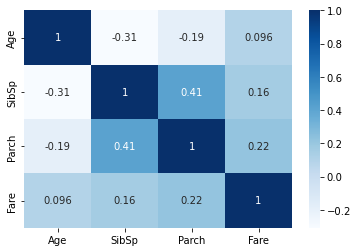

In [18]:
train_numeric_corr = train_numeric.corr()
sns.heatmap(data = train_numeric_corr, cmap = 'Blues', annot = True)
plt.show()

## Parch and SibSp has a slightly postive correlation between each other.

Since we are trying to predict the survival rate, lets take a look at the survivability of some of the passengers based on these numerical attributes.

In [19]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [20]:
train.pivot_table(index = 'Survived', values = train_numeric.columns, aggfunc = 'mean')

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.626179,22.117887,0.329690,0.553734
1,28.343690,48.395408,0.464912,0.473684


From the data obserbved, it looks like people with a much higher ticket fare seems to have survived the Titanic compared to people with loewr ticket fares. Other parameters do not show much significance towards the survivability of the passengers.

In [21]:
train['Embarked'].value_counts(0)

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [22]:
# Taking a look at the categorical values now
train_cat = train[['Embarked','Pclass','Sex']]
for i in train_cat.columns:
    print(train.pivot_table(index = 'Survived', columns = i, values = 'Parch', aggfunc = 'count'))
    print()

Embarked   C   Q    S
Survived             
0         75  47  427
1         93  30  217

Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119

Sex       female  male
Survived              
0             81   468
1            233   109



Majority of people heading over to Southampon (S) did not survive the incident. It is also observed that majority of people holding a class 3 ticket did not survive the incident as well. Survival rate of females are much higher compared to male passengers during the incident as well.

### Feature Engineering

For feature engineering, we will be looking at the remaining categories which are 'Name', 'Ticket' and 'Cabin' and determine whether these fields do impact the survivability of the passengers:


1) Does the title of the passenger matter/impact their survival?

2) What about their tickets purchased? Does that play a significant role to the survival of the passenger?

3) Does the Cabin the passenger is staying in affect their survival?

In [23]:
## Taking a look at the 'Name' field: Over here, we are more so interested in the title of the passenger (Mr/Mrs/Dr)
train['Title'] = train['Name'].apply(lambda x: x.split(',')[1].split('.')[0])

In [24]:
train_title = train.pivot_table(index = 'Title', columns = 'Survived', values = 'Embarked', aggfunc = 'count')
train_title['Survival_Rate'] = (train_title[1]/(train_title[0]+train_title[1]))*100
train_title.sort_values('Survival_Rate', ascending = False)

Survived,0,1,Survival_Rate
Title,,,
Mrs,26.0,98.0,79.032258
Miss,55.0,126.0,69.613260
Master,17.0,23.0,57.500000
Col,1.0,1.0,50.000000
Major,1.0,1.0,50.000000
Dr,4.0,3.0,42.857143
Mr,436.0,81.0,15.667311
Capt,1.0,NaN,NaN
Don,1.0,NaN,NaN


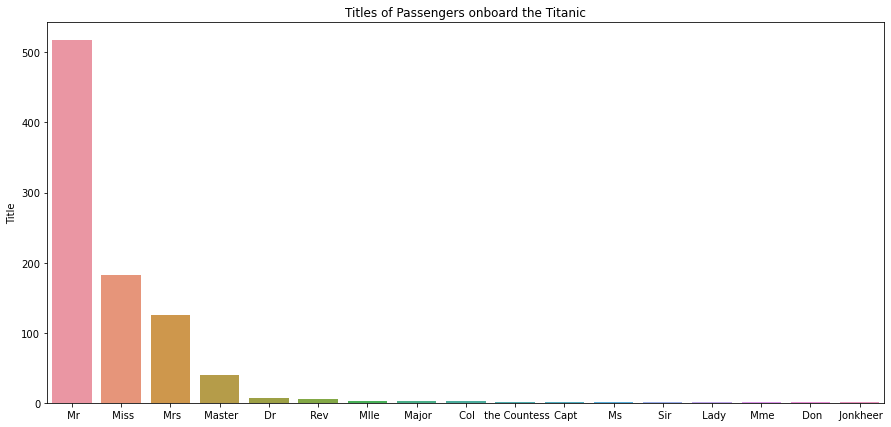

In [25]:
fig,ax = plt.subplots(figsize = (15,7))
sns.barplot(x = train['Title'].value_counts().index, y = train['Title'].value_counts(), data = train)
plt.title('Titles of Passengers onboard the Titanic')
plt.show()

As expected, majority of passengers have the title 'Mr' which indicates that majority of male passengers were present on the Titanic. Passengers with the highest survival rate are females, given by their titles (Mrs/Miss).

In [26]:
## Taking a look at the Cabin stayed in by the passengers.

In [27]:
## Taking a look at the tickets purchased by the passengers: From the data, we can classify the tickets to numeric and alphanumeric tickets
## All cabin has a alphabet infront, which probably signifies the cabin type that the passenger is staying in. We will be extracting the cabin type
## for further analysis.
train['Cabin'].str[0].unique()

array([nan, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [28]:
train['Cabin_Type'] = train['Cabin'].str[0]
train['Cabin_Type'].value_counts(dropna = False)
# train['Cabin_Type'].isna().sum()

NaN    687
C       59
B       47
D       33
E       32
A       15
F       13
G        4
T        1
Name: Cabin_Type, dtype: int64

In [29]:
train['Cabin_Type'] = train['Cabin_Type'].astype('string')
train['Cabin_Type'] = train['Cabin_Type'].apply(lambda x: 'NA' if pd.isna(x) else x)
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Cabin_Type
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,NA
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,NA
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,Rev,NA
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,Miss,B
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,Miss,NA
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,Mr,C


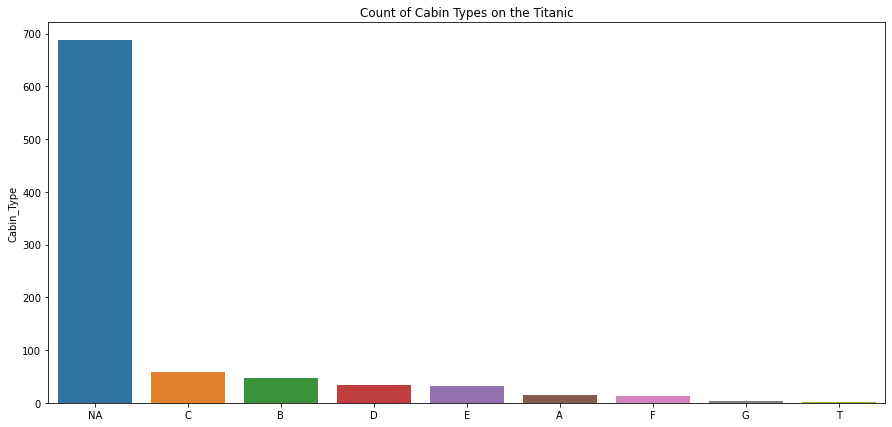

In [30]:
# NA here signifies NaN values for the 'Cabin_Type'
fig,ax = plt.subplots(figsize = (15,7))
sns.barplot(x = train['Cabin_Type'].value_counts(dropna = False).index, y = train['Cabin_Type'].value_counts(dropna = False), data = train)
plt.title('Count of Cabin Types on the Titanic')
plt.show()

In [31]:
train_cabin = train.pivot_table(index = 'Cabin_Type', columns = 'Survived', values = 'Embarked', aggfunc = 'count')
train_cabin['Survival_Rate'] = (train_cabin[1]/(train_cabin[0]+train_cabin[1]))*100
train_cabin.sort_values('Survival_Rate', ascending = False)

Survived,0,1,Survival_Rate
Cabin_Type,,,
D,8.0,25.0,75.757576
E,8.0,24.0,75.000000
B,12.0,33.0,73.333333
F,5.0,8.0,61.538462
C,24.0,35.0,59.322034
G,2.0,2.0,50.000000
A,8.0,7.0,46.666667
NA,481.0,206.0,29.985444
T,1.0,NaN,NaN


In [32]:
train.loc[train['Cabin_Type'] == 'T']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Cabin_Type
339,340,0,1,"Blackwell, Mr. Stephen Weart",male,45.0,0,0,113784,35.5,T,S,Mr,T


In [33]:
train.loc[train['Name'].str.contains(r'Cap',regex = True, flags = re.I)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Cabin_Type
745,746,0,1,"Crosby, Capt. Edward Gifford",male,70.0,1,1,WE/P 5735,71.0,B22,S,Capt,B


1) From the analysis, it was observed that passengers staying in Cabin D had the highest survival rate of 75%, making it the highest among the other cabins. 

2) The only passenger, Mr. Stephen Weart that was staying in Cabin T did not survive the incident.

3) The captain of the ship (Captain Edward Gifford) whom was staying in Cabin B (With a 73.33% surivival rate) did not make it through the incident, indicating he went down along with the ship, most likely attempting to help the passengers to escape safely. RIP

In [34]:
## Taking a look into the correlation between the tickets purchased and survival of passengers.
train.head()
## From the data, there are multiple ticket categories, which includes numeric, alphanumeric and purely alphabeltical tickets. We will split them 
## into 3 different categories and analyze the survival rates for these different ticket categories.

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Cabin_Type
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,NA
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,NA
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,NA


In [35]:
train['Ticket_category'] = train['Ticket'].apply(lambda x: 1 if x.isnumeric() else 2 if x.isalpha() else 3)
# Ticket category is split into 1: Numeric type tickets only, 2: alphabetical type tickets only and 3: Ticket Types with a combination of both/external symbols.

In [36]:
train.loc[train['Ticket'].str.isalpha()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Cabin_Type,Ticket_category
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S,Mr,NA,2
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S,Mr,NA,2
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S,Mr,NA,2
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S,Mr,NA,2


In [37]:
ticket_cat = train.pivot_table(index = 'Ticket_category', columns = 'Survived', values = 'Ticket', aggfunc = 'count')
ticket_cat['Survival_Rate'] = ticket_cat[1]/(ticket_cat[0]+ticket_cat[1])*100
ticket_cat.sort_values('Survival_Rate', ascending = False)

Survived,0,1,Survival_Rate
Ticket_category,,,
3,139,87,38.495575
1,407,254,38.426626
2,3,1,25.000000


### Data Preprocessing and Scaling

Here we will preprocess and scale our data for our model:

1) Transforming our test data similarly to what we did for our training set and combining them for overall processing.

2) Dropping unecessary/irrelevant fields (Passenger ID, Survived and our feature engineering prior to modification (Name, Cabin and Tickets since we will be taking the modified versions of these fields)).

3) Normalizing our data

4) Creating dummy variables for our data

5) Splitting our train and test data out again

In [38]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [39]:
test['Title'] = test['Name'].apply(lambda x: x.split(',')[1].split('.')[0])
test['Cabin_Type'] = test['Cabin'].str[0]
test['Cabin_Type'] = test['Cabin_Type'].apply(lambda x: 'NA' if pd.isna(x) else x)
test['Ticket_category'] = test['Ticket'].apply(lambda x: 1 if x.isnumeric() else 2 if x.isalpha() else 3)

In [40]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Ticket_category
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000,418.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188,1.583732
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576,0.910332
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000,1.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800,1.000000
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200,1.000000
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000,3.000000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200,3.000000


In [41]:
train['Data_Category'] = 1
test['Data_Category'] = 0

In [42]:
combine = pd.concat([train,test])
combine.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Cabin_Type,Ticket_category,Data_Category
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,NA,3,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,C,3,1
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,NA,3,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,C,1,1
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,NA,1,1


In [43]:
combine.isna().sum().sort_values(ascending = False)
# We can replace missing values from age and fare with either the mean/median depending on the distribution of the data.

Cabin              1014
Survived            418
Age                 263
Embarked              2
Fare                  1
PassengerId           0
Pclass                0
Name                  0
Sex                   0
SibSp                 0
Parch                 0
Ticket                0
Title                 0
Cabin_Type            0
Ticket_category       0
Data_Category         0
dtype: int64

In [44]:
combine.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Ticket_category,Data_Category
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,1309.000000,1309.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479,1.534759,0.680672
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668,0.883794,0.466394
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800,1.000000,0.000000
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000,1.000000
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000,3.000000,1.000000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200,3.000000,1.000000


In [45]:
# Dropping the rows with missing 'Embarked' fields
combine.dropna(subset = 'Embarked', inplace = True)

In [46]:
# Filling the missing values for both Age and Fare fields with the median values.
combine['Age'].fillna(train['Age'].median(), inplace = True)
combine['Fare'].fillna(train['Fare'].median(), inplace = True)

In [47]:
combine.isna().sum(0)

PassengerId           0
Survived            418
Pclass                0
Name                  0
Sex                   0
Age                   0
SibSp                 0
Parch                 0
Ticket                0
Fare                  0
Cabin              1014
Embarked              0
Title                 0
Cabin_Type            0
Ticket_category       0
Data_Category         0
dtype: int64

In [48]:
#Dropping irrelevant fields ('PassengerId')
combine.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title', 'Cabin_Type',
       'Ticket_category', 'Data_Category'],
      dtype='object')

In [49]:
combine.isna().sum()

PassengerId           0
Survived            418
Pclass                0
Name                  0
Sex                   0
Age                   0
SibSp                 0
Parch                 0
Ticket                0
Fare                  0
Cabin              1014
Embarked              0
Title                 0
Cabin_Type            0
Ticket_category       0
Data_Category         0
dtype: int64

In [50]:
## Creating our dummy variables
combine_dummy = pd.get_dummies(combine[['Pclass', 'Sex', 'Age', 'SibSp',
       'Parch', 'Fare', 'Embarked', 'Title', 'Cabin_Type',
       'Ticket_category', 'Data_Category']])

combine_dummy

,Pclass,Age,SibSp,Parch,Fare,Ticket_category,Data_Category,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_ Capt,Title_ Col,Title_ Don,Title_ Dona,Title_ Dr,Title_ Jonkheer,Title_ Lady,Title_ Major,Title_ Master,Title_ Miss,Title_ Mlle,Title_ Mme,Title_ Mr,Title_ Mrs,Title_ Ms,Title_ Rev,Title_ Sir,Title_ the Countess,Cabin_Type_A,Cabin_Type_B,Cabin_Type_C,Cabin_Type_D,Cabin_Type_E,Cabin_Type_F,Cabin_Type_G,Cabin_Type_NA,Cabin_Type_T
0,3,22.0,1,0,7.2500,3,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,1,38.0,1,0,71.2833,3,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,3,26.0,0,0,7.9250,3,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,1,35.0,1,0,53.1000,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
4,3,35.0,0,0,8.0500,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,3,28.0,0,0,8.0500,3,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
414,1,39.0,0,0,108.9000,3,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
415,3,38.5,0,0,7.2500,3,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
416,3,28.0,0,0,8.0500,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [51]:

# Splitting to train and test sets again# Splitting to train and test sets again
train_dummy = combine_dummy.loc[combine_dummy['Data_Category'] == 1]
test_dummy = combine_dummy.loc[combine_dummy['Data_Category'] == 0]

In [52]:
# Splitting out the field that we are trying to predict from our training set.
train_dummy_y = combine.loc[combine['Data_Category'] == 1]
train_dummy_y = train_dummy_y['Survived']
train_dummy_y.shape

(889,)

In [53]:
test_dummy_y = combine.loc[combine['Data_Category'] == 0]
test_dummy_y = test_dummy_y['Survived']
test_dummy_y.shape

(418,)

Now we scale our data:

In [54]:
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()

train_dummy_scale = scale.fit_transform(train_dummy)
test_dummy_scale = scale.fit_transform(test_dummy)

### Building Our Model

Models that we will be validating with:

1) K Nearest Neighbor

2) Naive Bayes 

3) Logistic Regression

4) Random Forest

5) Support Vector Classifier

In [55]:
# Importing our models

from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [56]:
# Naive Bayes used as baseline for model building
gnb = GaussianNB()
cv = cross_val_score(gnb,train_dummy_scale,train_dummy_y,cv = 5)
print(cv)
print(cv.mean())

[0.65168539 0.64606742 0.75280899 0.73033708 0.72881356]
0.7019424871453056


In [57]:
# Logistic Regression
log = LogisticRegression(max_iter = 2000)
cv = cross_val_score(log,train_dummy_scale,train_dummy_y,cv = 5)
print(cv)
print(cv.mean())

[0.81460674 0.81460674 0.80337079 0.80898876 0.85875706]
0.8200660191709515


In [58]:
svc = SVC(probability = True)
cv = cross_val_score(svc,train_dummy_scale,train_dummy_y,cv = 5)
print(cv)
print(cv.mean())

[0.83146067 0.79775281 0.81460674 0.80898876 0.84745763]
0.8200533231765377


In [59]:
# KNN
knn = KNeighborsClassifier(n_neighbors=5)
cv = cross_val_score(knn,train_dummy_scale,train_dummy_y,cv = 5)
print(cv)
print(cv.mean())

[0.8258427  0.7752809  0.80898876 0.76966292 0.84180791]
0.8043166381006792


In [60]:
# Random Forest
rand = RandomForestClassifier(random_state = 1)
cv = cross_val_score(rand,train_dummy_scale,train_dummy_y,cv = 5)
print(cv)
print(cv.mean())

[0.82022472 0.7752809  0.83146067 0.73033708 0.83615819]
0.7986923125753824


After performing cross validation on the models, Logistic Regression has the highest CV score of 82.006. Hence the model will be selected to predict the survivability of the passengers.

In [61]:
log = LogisticRegression(max_iter = 2000)
log.fit(train_dummy,train_dummy_y)

LogisticRegression(max_iter=2000)

In [78]:
y_pred = log.predict(test_dummy_scale).astype('int')

C:\Users\gibso\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [79]:
y_pred.shape

(418,)

In [80]:
test.shape

(418, 15)

In [83]:
# print(classification_report(y_pred, test_dummy_y))
## Converting output into a dataframe for submission
sub = {'PassengerId': test['PassengerId'], 'Survived': y_pred}
# sub = {'Survived': y_pred}
submission = pd.DataFrame(data = sub)
submission.to_csv('./lr_submission.csv', index = False)